In [1]:
# data stuff:
import pandas as pd
import numpy as np
import optuna
from tqdm import tqdm

# plotting stuff:
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image

# stats stuff:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error

# silence!
import warnings
warnings.filterwarnings("ignore")

---
### The VARMAX Model:
VARMAX is the go-to model for multivariate time-series modelling. As with univariate models we've seen before, it builds upon more basic models. Namely, it adds **MA** (Moving Average) to VAR model, as well as **X** for exogenous/external variables. 

Model definition:
$$y_{t}=v+A_{1} y_{t-1}+\cdots+A_{p} y_{t-p}+B x_{t}+\epsilon_{t}+M_{1} \epsilon_{t-1}+\cdots+M_{q} \epsilon_{t-q}$$

where:

* $y_t$ is a vector containg the current (present) values for each of the variables,

* $p$ is the parameter that controls the number of lags that the model will use (how many steps in the past to look),

* $A$ are the autocorrelation coefficients for each lag (they are a vector of the same length as the number of the time-series),

* $M_s$ are vectors of coefficients for the lagged errors,

* $\epsilon_t$ are the error terms.


<div class="alert alert-block alert-warning">
<b>Note:</b>
    
Like the univariate models we have seen in the past, the VARMAX model relies on the assumption of <b>stationarity</b>. This assumes that all of the variables used in the model are stationary. As such, no integration term is included. 
</div>


<div class="alert alert-block alert-warning">
<b>Additional Note:</b>
  
VARMAX does not include a seasonal component in the model. However, this is not a problem. Seasonality can be included as an exogenous variable by adding a month variables for monthly seasonality, or week number for weekly seasonality.
</div>

---

### Import data and prepare:

Below, we follow the same recipe we have used before in the VAR model, namely, we aggregate on a per-store basis. Additionally, we include an exogenous term by keeping track of the holiday indicator.

In [6]:
# read original set:
data = pd.read_csv('data/walmart_train.csv')

# create exogenous variable
exog = data.groupby('Date')['IsHoliday'].sum() > 0
exog = exog.apply(float)
exog

Date
2010-02-05    0.0
2010-02-12    1.0
2010-02-19    0.0
2010-02-26    0.0
2010-03-05    0.0
             ... 
2012-09-28    0.0
2012-10-05    0.0
2012-10-12    0.0
2012-10-19    0.0
2012-10-26    0.0
Name: IsHoliday, Length: 143, dtype: float64

In [7]:
# pivot to obtain per-store counts:
data = data.pivot_table(index='Date', columns='Store', values='Weekly_Sales')

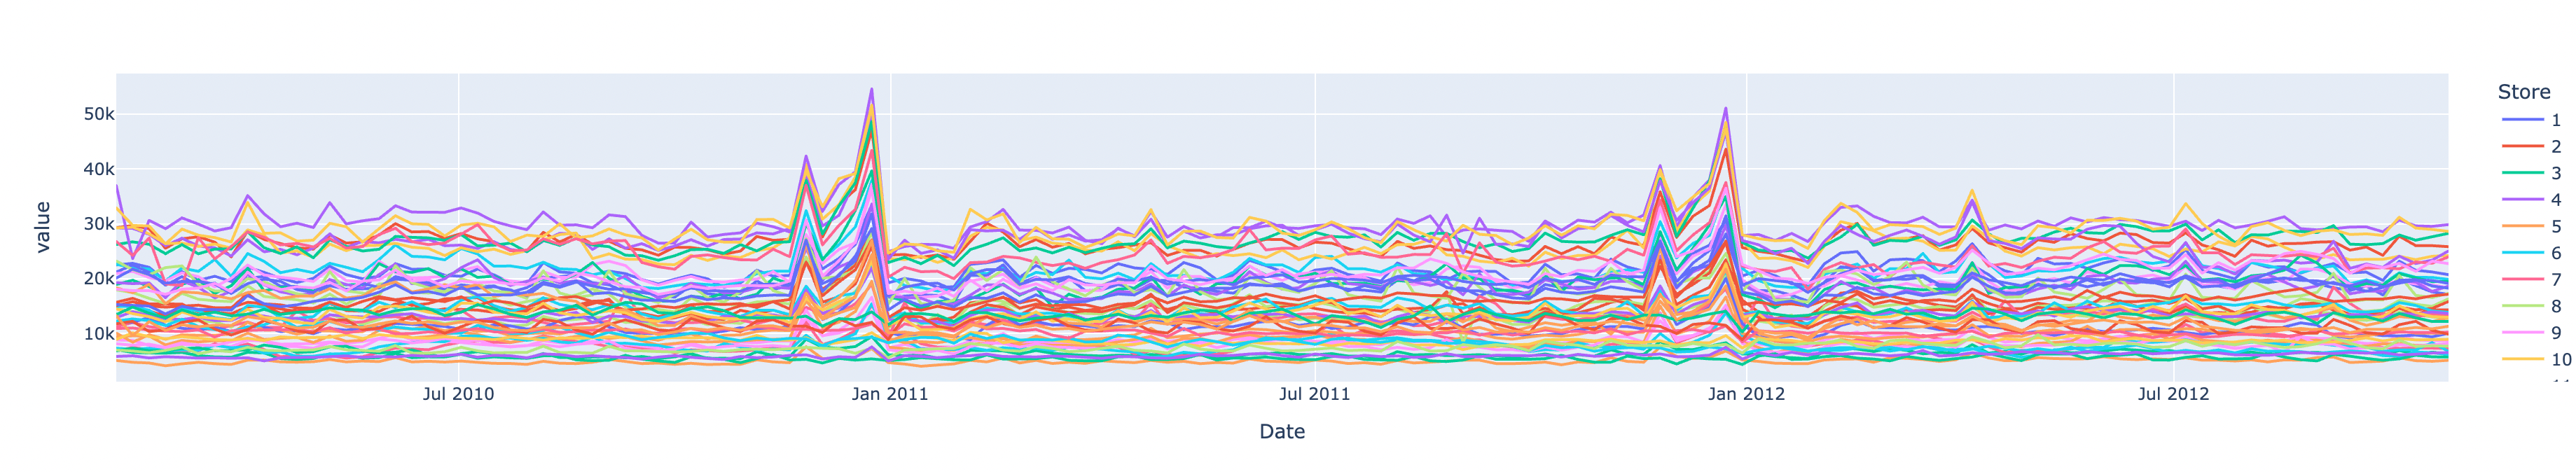

In [11]:
px.line(data)
Image(filename='./images/ch10_seriesplot.png', width=1600)

### Fit a VARMAX model (all 45 stores):
**Note:** unlike the VAR model for which we only needed to worry about the "lag" parameter, in VARMAX we need to consider the "p" parameter that controls the AR lag, in addition to the "q" parameter that controls the MA lag. Thus we describe the model as **MARMAX(p, q)**.

<div class="alert alert-block alert-warning">
<b>Additional Note:</b>
  
VARMAX can take a very long time to fit due to the MA component present in the model. It is exceptionally slow for datasets with many variables (45 in our case). 
</div>

In [9]:
train = data.iloc[:-10,:]
test = data.iloc[-10:,:]

train_exog = exog[:-10]
test_exog = exog[-10:]

mod = sm.tsa.VARMAX(train, order=(1,1), exog=train_exog)
res = mod.fit(maxiter=100, disp=False)

fcst = res.forecast(exog=test_exog.values, steps=10)
mape = mean_absolute_percentage_error(test, fcst)
model_accuracy = 1 - mape
print(model_accuracy)

0.9312242029108945


**Note:**

The accuracy results above are about 3% lower than the score in the book (see "Advanced Forecasting with Python" page 144). However, the author only used 3 out of the total of 45 stores in order to fit his model (we used all 45). As we can see in the correlation plot in the previous section, some stores are not strongly correlated with others at all, while others are strongly correlated and even negatively correlated. I surmise this might have had an effect in the drop in accuracy seen above. 

### Fit a VARMAX model (with fewer variables - 3 stores):

In [10]:
train = data.iloc[:-10,[0,1,2]]
test = data.iloc[-10:,[0,1,2]]

train_exog = exog[:-10]
test_exog = exog[-10:]

mod = sm.tsa.VARMAX(train, order=(1,1), exog=train_exog)
res = mod.fit(maxiter=100, disp=False)

fcst = res.forecast(exog=test_exog.values, steps=10)
mape = mean_absolute_percentage_error(test, fcst)
model_accuracy = 1 - mape
print(model_accuracy)

0.962077023980244
